In [533]:
# Import all the required libraries
import os
from google.colab import files
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Data Collection and Preprocessing

In [496]:
# Upload the Telco Customer Churn dataset CSV from local Drive
upload_file = files.upload()
list_files = os.listdir()

Saving Telco_Customer_Churn.csv to Telco_Customer_Churn (12).csv


In [497]:
# Read the data from the CSV file into DataFrame
file_name = 'Telco_Customer_Churn.csv';
data = pd.read_csv(file_name)
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


## Handling Missing Values

Let us check for any missing values (whitespaces) in our dataset.

In [498]:
# Regex to replace the whitespace with NaN
data = data.replace(r'^\s*$', np.nan, regex=True)

# Calculate the count of null values in each column
null_counts = data.isnull().sum()

# Filter and print columns with null values (count greater than 0)
print(null_counts[null_counts > 0])

TotalCharges    11
dtype: int64


We can see that `'TotalCharges'` is the only column that has missing values. We can calculate the missing values by using the `'tenure'`, `'MonthlyCharges'`, `'Contract'` columns.

In [499]:
# Get the indices of rows where 'TotalCharges' is null in the 'data' DataFrame
data[data['TotalCharges'].isnull()].index.tolist()

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]

In [500]:
# Find indices where 'TotalCharges' is null
indices_with_null_total_charges = data[data['TotalCharges'].isnull()].index.tolist()

# Iterate through the indices
for idx in indices_with_null_total_charges:
    # Extract relevant information for the current index
    tenure = int(np.maximum(data['tenure'].loc[idx], 1))
    monthly_charges = data['MonthlyCharges'].loc[idx]

    # Determine the multiplier based on the contract type
    if data['Contract'].loc[idx] == 'Two year':
        contract_multiplier = 24
    elif data['Contract'].loc[idx] == 'One year':
        contract_multiplier = 12
    else:
        contract_multiplier = 1

    # Calculate and assign the 'TotalCharges' value
    data.loc[idx, 'TotalCharges'] = tenure * monthly_charges * contract_multiplier

# Display the total NaN values in each columns
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Lastly, let's check for any duplicate rows in the dataset.

In [501]:
# Count and print the number of duplicated rows in the DataFrame
print(f'Duplicate Rows: {data.duplicated().sum()}')

Duplicate Rows: 0


Since the `'TotalCharges'` column is stored as an object, we explicitly change the type to 'float64' and store the result in respective column.

In [502]:
# Convert 'TotalCharges' to numeric if it's not already numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

## Label Encoding

We will now encode categorical columns with binary value ('Yes' and 'No') with numerical representation ('1' and '0') for calculation.

In [503]:
# Initialize a counter for affected columns
affected_columns_count = 0

# Iterate through columns
for column in data.columns:
    # Check if all unique values in the column are 'Yes' or 'No'
    if set(data[column].unique()) == {'Yes', 'No'}:
        # Replace 'Yes' with 1 and 'No' with 0
        data[column] = data[column].replace({'Yes': 1, 'No': 0})
        affected_columns_count += 1

# Display the count of affected columns
print(f'{affected_columns_count} columns were affected.')

5 columns were affected.


# Exploratory Data Analysis (EDA)

In [504]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


In [505]:
print(data.describe())

       SeniorCitizen      Partner   Dependents       tenure  PhoneService  \
count    7043.000000  7043.000000  7043.000000  7043.000000   7043.000000   
mean        0.162147     0.483033     0.299588    32.371149      0.903166   
std         0.368612     0.499748     0.458110    24.559481      0.295752   
min         0.000000     0.000000     0.000000     0.000000      0.000000   
25%         0.000000     0.000000     0.000000     9.000000      1.000000   
50%         0.000000     0.000000     0.000000    29.000000      1.000000   
75%         0.000000     1.000000     1.000000    55.000000      1.000000   
max         1.000000     1.000000     1.000000    72.000000      1.000000   

       PaperlessBilling  MonthlyCharges  TotalCharges        Churn  
count       7043.000000     7043.000000   7043.000000  7043.000000  
mean           0.592219       64.761692   2281.253259     0.265370  
std            0.491457       30.090047   2265.703526     0.441561  
min            0.000000       

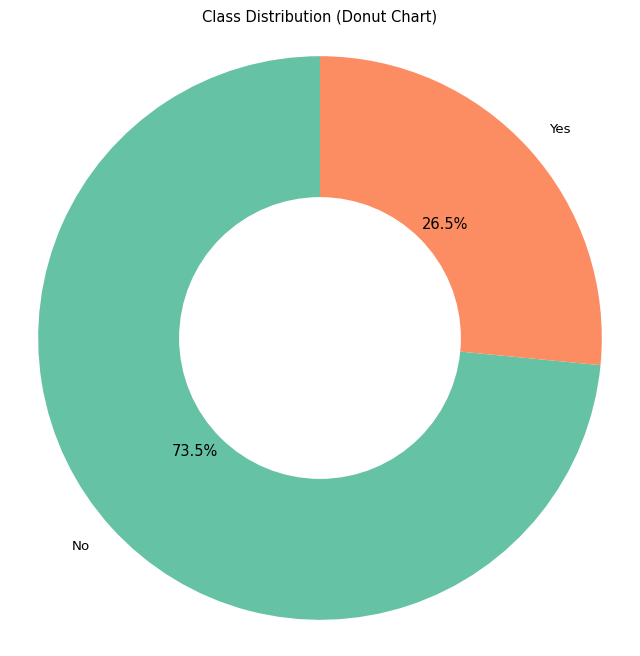

In [506]:
# Visualize class distribution using a donut chart
class_distribution = data['Churn'].value_counts()

plt.figure(figsize=(8, 8))

# Create a pie chart with labels 'No' and 'Yes'
plt.pie(class_distribution, labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))

# Draw a white circle at the center to create a donut effect
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that the pie is drawn as a circle.
plt.axis('equal')

plt.title('Class Distribution (Donut Chart)')
plt.show()

From the donut chart above, we can see that the data is imbalanced and 26.5% of the customers switched to another service provider.

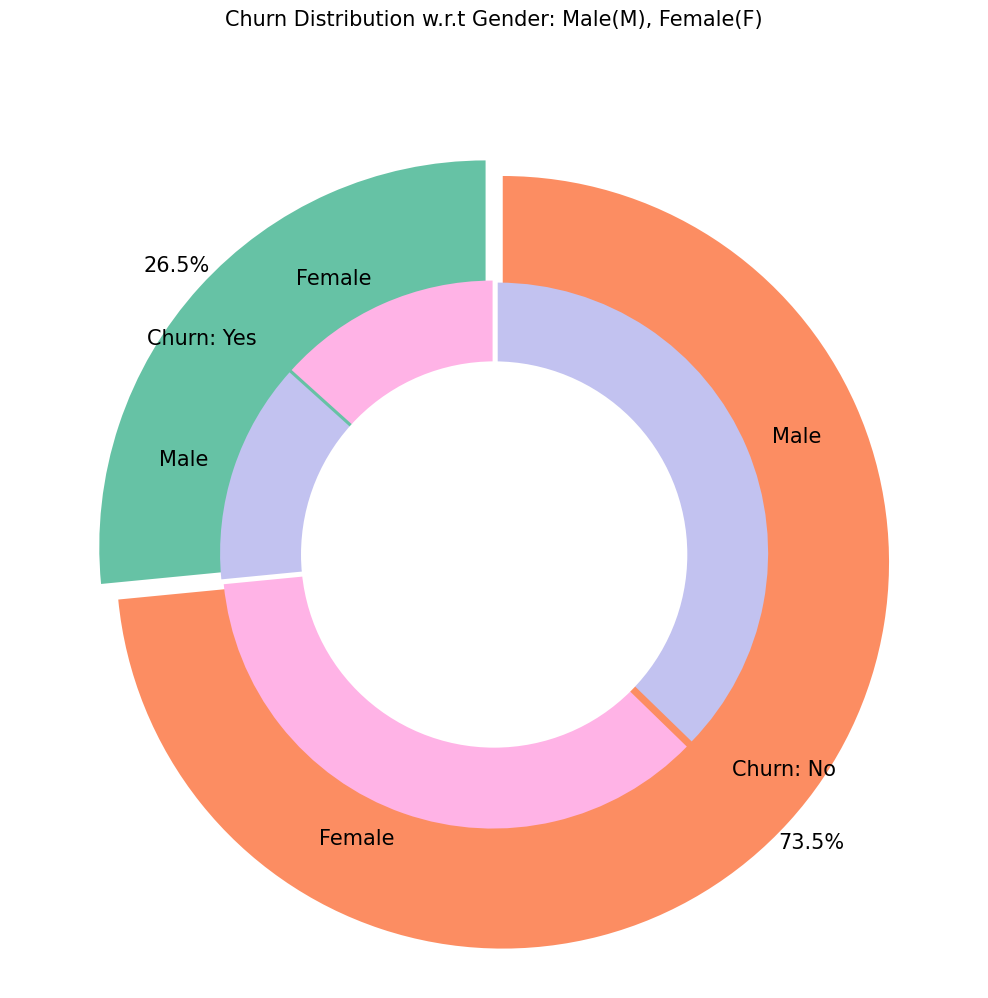

In [507]:
# Churn data
churn_labels = ["Churn: Yes", "Churn: No"]
churn_values = [data[data['Churn'] == 1].shape[0], data[data['Churn'] == 0].shape[0]]

# Gender data
gender_labels = ["Female", "Male", "Female", "Male"]
male_churn_yes_count = data[data['Churn'] == 1].loc[data['gender'] == 'Male'].shape[0]
female_churn_yes_count = data[data['Churn'] == 1].loc[data['gender'] == 'Female'].shape[0]
male_churn_no_count = data[data['Churn'] == 0].loc[data['gender'] == 'Male'].shape[0]
female_churn_no_count = data[data['Churn'] == 0].loc[data['gender'] == 'Female'].shape[0]
gender_sizes = [female_churn_yes_count, male_churn_yes_count, female_churn_no_count, male_churn_no_count]

# Colors for plots
churn_colors = sns.color_palette('Set2')
gender_colors = ['#ffb3e6', '#c2c2f0', '#ffb3e6', '#c2c2f0']

# Explosion settings
churn_explode = (0.3, 0.3)
gender_explode = (0.1, 0.1, 0.1, 0.1)

# Text properties for labels
text_props = {"fontsize": 15}

# Plot Churn distribution
plt.figure(figsize=(10, 10))

# Churn pie chart
plt.pie(churn_values, labels=churn_labels, autopct='%1.1f%%', pctdistance=1.08, labeldistance=0.8,
        colors=churn_colors, startangle=90, frame=True, explode=churn_explode, radius=10, textprops=text_props,
        counterclock=True)

# Gender pie chart
plt.pie(gender_sizes, labels=gender_labels, colors=gender_colors, startangle=90, explode=gender_explode, radius=7,
        textprops=text_props, counterclock=True)

# Draw circle in the center
centre_circle = plt.Circle((0, 0), 5, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set title
plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# Show plot
plt.axis('equal')
plt.tight_layout()
plt.show()

The customer who switched service providers did not differ significantly. When it came to switching to a different service provider, both genders acted similarly.

In [508]:
# Create a histogram
fig = px.histogram(
    data, x="Churn", color="Contract", barmode="group", title="Customer Contract Distribution",
    color_discrete_map={
        "Month-to-month": "#5758BB",
        "One year": "#9980FA",
        "Two year": "#D980FA"
    }
)

# Update the layout settings of the histogram
fig.update_layout(width=700, height=500, bargap=0.2)

# Update x-axis tick labels
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['No', 'Yes'],
    title_text="Churn"
)

fig.show()

Compared to customers with a one-year or two-year contract, those with a month-to-month charge are more likely to opt out. This makes sense in practice because customers with long-term contracts tend to be more devoted to their companies.

In [509]:
# Create a box plot using Plotly Express
fig = px.box(data, x='Churn', y='tenure')

# Update y-axis title and x-axis title
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size, title font, and plot title
fig.update_layout(
    autosize=True,  # Adjust size automatically
    width=750,      # Set width of the plot
    height=600,     # Set height of the plot
    title_font=dict(size=25, family='Courier'),  # Title font properties
    title='Tenure vs Churn',  # Set the plot title with HTML formatting
)

# Update x-axis tick labels
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['No', 'Yes'],
    title_text="Churn"
)

# Display the updated plot
fig.show()

From the figure above, we can see that the new customers are more likely to churn.

In [510]:
# Create a new Figure object
fig = go.Figure()

# Add trace for 'DSL' Internet Service
dsl_churn_no_count = data[data['Churn'] == 0].loc[data['InternetService'] == 'DSL'].shape[0]
dsl_churn_yes_count = data[data['Churn'] == 1].loc[data['InternetService'] == 'DSL'].shape[0]
fig.add_trace(go.Bar(
    x=['Churn:No','Churn:Yes'],
    y=[dsl_churn_no_count, dsl_churn_yes_count],
    name='DSL',
))

# Add trace for 'Fiber optic' Internet Service
fiber_optic_churn_no_count = data[data['Churn'] == 0].loc[data['InternetService'] == 'Fiber optic'].shape[0]
fiber_optic_churn_yes_count = data[data['Churn'] == 1].loc[data['InternetService'] == 'Fiber optic'].shape[0]
fig.add_trace(go.Bar(
    x=['Churn:No', 'Churn:Yes'],
    y=[fiber_optic_churn_no_count, fiber_optic_churn_yes_count],
    name='Fiber optic',
))

# Add trace for 'No Internet' Service
no_internet_churn_no_count = data[data['Churn'] == 0].loc[data['InternetService'] == 'No'].shape[0]
no_internet_churn_yes_count = data[data['Churn'] == 1].loc[data['InternetService'] == 'No'].shape[0]
fig.add_trace(go.Bar(
    x=['Churn:No', 'Churn:Yes'],
    y=[no_internet_churn_no_count, no_internet_churn_yes_count],
    name='No Internet',
))

# Update layout settings
fig.update_layout(
    title='Churn Distribution based on Internet Service'
)

# Display the plot
iplot(fig)

The figure above shows that lots of customer chooses fiber optic service and these customers have a high rate of customer churn. This indicates discontent with this type of internet service.

Moreover, compared to fiber optic service, there are majority of DSL customers and have lower churn rate.

In [511]:
# Define a color map for 'Dependents' categories
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}

# Create a histogram using Plotly Express
fig = px.histogram(
    data,  # DataFrame containing the data
    x="Churn",  # Data to be represented on the x-axis
    color="Dependents",  # Categorization by 'Dependents' for color differentiation
    barmode="group",  # Set the bar mode to 'group' for grouped bars
    title="Churn distribution based on Dependents",  # Title of the histogram with HTML formatting
    color_discrete_map=color_map  # Apply the defined color map to 'Dependents'
)

# Update layout settings for the histogram
fig.update_layout(
    width=700,  # Set the width of the plot
    height=500,  # Set the height of the plot
    bargap=0.1  # Set the gap between bars
)

# Update x-axis tick labels
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['No', 'Yes'],
    title_text="Churn"
)

# Display the histogram
fig.show()

The above graph illustrates how churn is more likely to happen among customers without dependents.

In [512]:
# Define a color map for the 'Partner' categories
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}

# Create a histogram using Plotly Express
fig = px.histogram(
    data,
    x="Churn",
    color="Partner",
    barmode="group",
    title="Churn distribution based on Partners",
    color_discrete_map=color_map
)

# Update layout settings for the histogram
fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

# Update x-axis tick labels
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['No', 'Yes'],
    title_text="Churn"
)

# Display the histogram
fig.show()

Above figure illustrates that customers with no partners are more likely to churn.

In [513]:
# Define a color map for the 'Partner' categories
color_map = {"Yes": '#00CC96', "No": '#B6E880'}

# Create a histogram using Plotly Express
fig = px.histogram(
    data,
    x="Churn",
    color="SeniorCitizen",
    barmode="stack",
    title="Churn distribution based on Senior Citizen",
    color_discrete_map=color_map
)

# Update layout settings for the histogram
fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

# Update x-axis tick labels
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['No', 'Yes'],
    title_text="Churn"
)

# Display the histogram
fig.show()

Above figure illustrates identical result regardless of the SeniorCitizen status, thus it does not contribute much towards our analysis.

In [514]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}

# Create a histogram using Plotly Express
fig = px.histogram(
    data,
    x="Churn",
    color="OnlineSecurity",
    barmode="group",
    title="Churn distribution based on Online Security",
    color_discrete_map=color_map
)

# Update layout settings for the histogram
fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

# Update x-axis tick labels
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['No', 'Yes'],
    title_text="Churn"
)

# Display the histogram
fig.show()

The bar chart above demonstrates that customer are more likely to churn in the absence online security.

In [515]:
color_map = {"Yes": '#FFA15A', "No": '#00CC96'}

# Create a histogram using Plotly Express
fig = px.histogram(
    data,
    x="Churn",
    color="PaperlessBilling",
    barmode="group",
    title="Churn distribution based on Paperless Billing",
    color_discrete_map=color_map
)

# Update layout settings for the histogram
fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

# Update x-axis tick labels
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['No', 'Yes'],
    title_text="Churn"
)

# Display the histogram
fig.show()

The provided bar chart illustrates that customers with paperless billing are more prone to churn.

In [516]:
color_map = {"Yes": "#FF97FF", "No": "#AB63FA"}

# Create a histogram using Plotly Express
fig = px.histogram(
    data,
    x="Churn",
    color="TechSupport",
    barmode="group",
    title="Churn distribution based on Tech Support",
    color_discrete_map=color_map
)

# Update layout settings for the histogram
fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

# Update x-axis tick labels
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['No', 'Yes'],
    title_text="Churn"
)

# Display the histogram
fig.show()

The bar chart above indicates that customers without technical support are more inclined to switch to a different service provider.

In [517]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}

# Create a histogram using Plotly Express
fig = px.histogram(
    data,
    x="Churn",
    color="PhoneService",
    barmode="group",
    title="Churn distribution based on Phone Service",
    color_discrete_map=color_map
)

# Update layout settings for the histogram
fig.update_layout(
    width=700,
    height=500,
    bargap=0.1
)

# Update x-axis tick labels
fig.update_xaxes(
    tickvals=[0, 1],
    ticktext=['No', 'Yes'],
    title_text="Churn"
)

# Display the histogram
fig.show()

A tiny percentage of customers lack phone service, and within that group, approximately 25% are at a higher risk of churning.

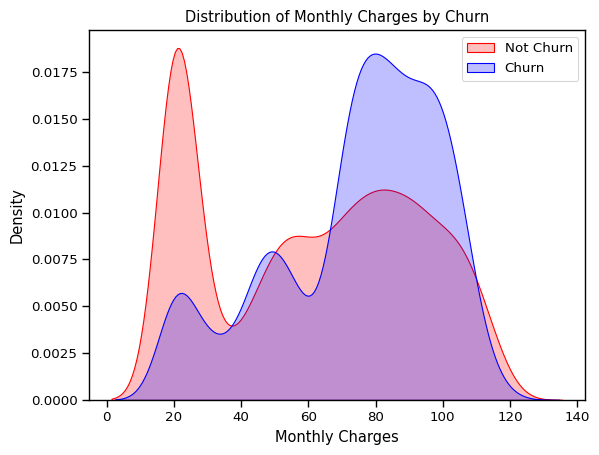

In [518]:
# Set the context and font scale for the plot
sns.set_context("paper", font_scale=1.1)

# Create a kernel density plot (KDE) for Monthly Charges based on churn status
ax = sns.kdeplot(data.MonthlyCharges[data["Churn"] == 0], color="Red", shade=True)
ax = sns.kdeplot(data.MonthlyCharges[data["Churn"] == 1], ax=ax, color="Blue", shade=True)

# Add legend and labels to the plot
ax.legend(["Not Churn", "Churn"], loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of Monthly Charges by Churn')

plt.show()  # Show the plot

From the figure above, it can be seen that the customers with higher monthly charges are more likely to churn and vice-versa.

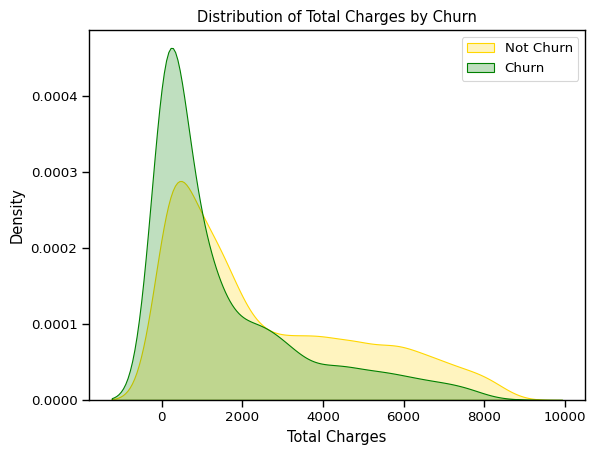

In [519]:
# Create kernel density plot (KDE) for Total Charges based on churn status using Seaborn
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 0)], color="Gold", shade=True)
ax = sns.kdeplot(data.TotalCharges[(data["Churn"] == 1)], ax=ax, color="Green", shade=True)

# Add legend and labels to the plot
ax.legend(["Not Churn", "Churn"], loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of Total Charges by Churn')

plt.show()

The line graph illustrates that customers with elevated total charges are at a greater risk of churning.

## Correlation between the columns in the dataset

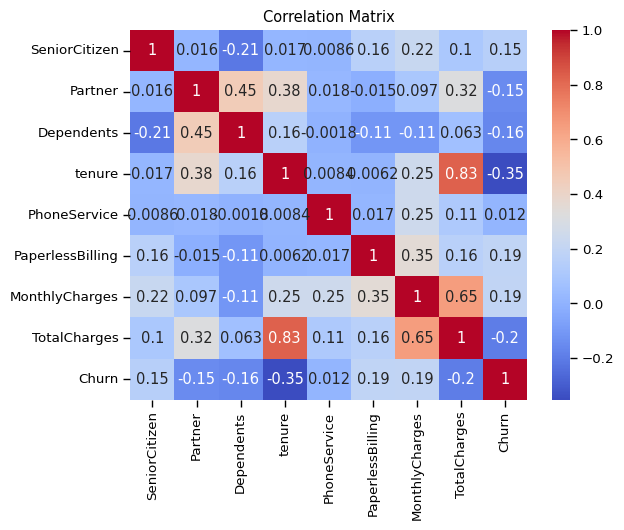

In [520]:
# Calculate the correlation matrix of the dataset
correlation_matrix = data.corr()

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

# Set the title of the heatmap
plt.title("Correlation Matrix")

# Display the heatmap
plt.show()

With warmer colors, like red, indicating a strong positive correlation and cooler colors, like blue, indicating a strong negative correlation, this visualization aids in understanding the relationships between the various features in the dataset. Furthermore, a stronger positive or negative linear relationship between the variables is indicated by values that are closer to 1 or -1, respectively. A weak linear relationship is indicated by a value close to 0.

From the above figure, we can see few strong corelation between `'tenure'` and `'TotalCharges'` and `'MonthlyCharges'` and `'TotalCharges'`.

## Outlier Detection
When dealing with numerical variables, it is important to assess the existence of outliers, as they have the potential to adversely impact training quality and diminish the overall performance of predictive models.

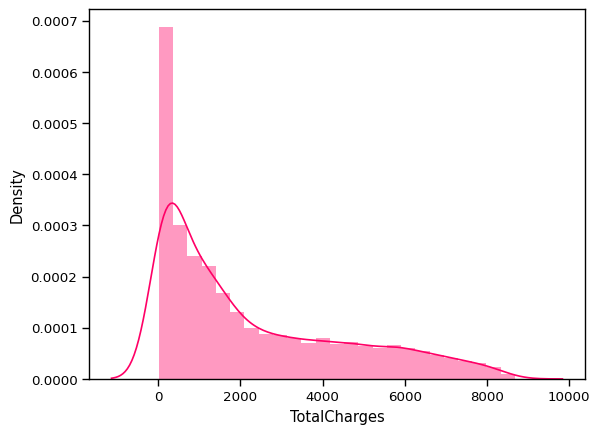

In [521]:
sns.distplot(data['TotalCharges'], color='#ff0066');

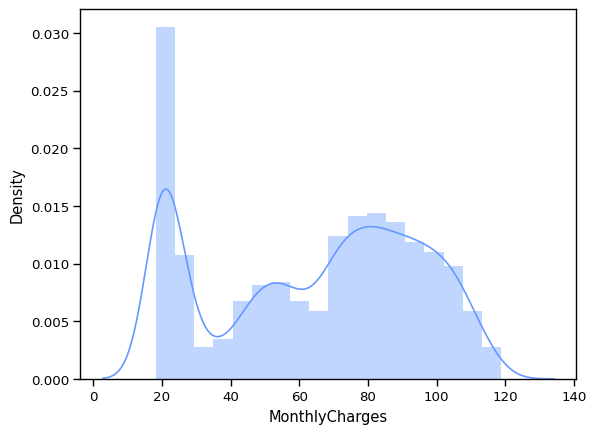

In [522]:
sns.distplot(data['MonthlyCharges'], color="#6699ff");

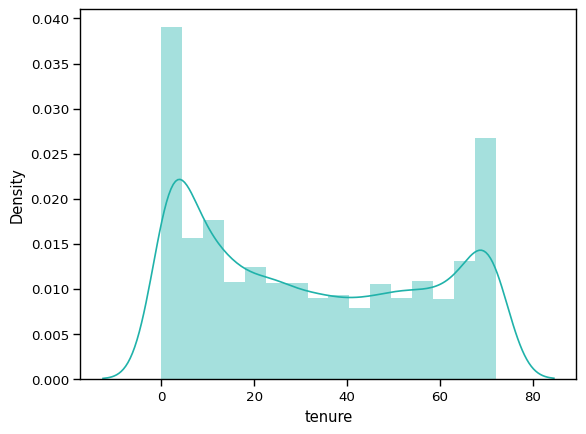

In [523]:
sns.distplot(data['tenure'], color="lightseagreen");

An alternative method for illustrating outliers involves the utilization of boxplots and whiskers. This representation showcases the quantile (box) and inter-quantile range (whiskers), with outliers depicted beyond the error bars (whiskers).

In [524]:
# Create a subplot with three box plots for numerical variables: 'MonthlyCharges', 'TotalCharges', and 'tenure'
fig = make_subplots(rows=1, cols=3)

# Box plot for 'MonthlyCharges'
fig.add_trace(go.Box(y=data['MonthlyCharges'], notched=True, name='Monthly Charges', marker_color='#6699ff',
                     boxmean=True, boxpoints='suspectedoutliers'), row=1, col=2)

# Box plot for 'TotalCharges'
fig.add_trace(go.Box(y=data['TotalCharges'], notched=True, name='Total Charges', marker_color='#ff0066',
                     boxmean=True, boxpoints='suspectedoutliers'), row=1, col=1)

# Box plot for 'tenure'
fig.add_trace(go.Box(y=data['tenure'], notched=True, name='Tenure', marker_color='lightseagreen',
                     boxmean=True, boxpoints='suspectedoutliers'), row=1, col=3)

# Update the layout with a title
fig.update_layout(title_text='Box Plots for Numerical Variables')

# Display the plot
iplot(fig)

In [525]:
def detect_outliers(features):
    """
    Detect and print outlier points for specified numerical features.

    Parameters:
    - features (list): List of numerical feature names to analyze for outliers.
    """
    for feature in features:
        # Calculate the Interquartile Range (IQR) and upper/lower bounds
        Q3, Q1 = np.percentile(data[feature], [75, 25])
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR

        # Identify and print outlier points
        outliers = data[feature][(data[feature] > upper_limit) | (data[feature] < lower_limit)]

        # Print results in a more readable format
        print(f'Outliers for {feature}:')
        if outliers.empty:
            print('No outliers found.\n')
        else:
            print(outliers.to_string(index=False) + '\n')

# Detect outliers for the specified features: 'tenure', 'MonthlyCharges', 'TotalCharges'
detect_outliers(['tenure', 'MonthlyCharges', 'TotalCharges'])

Outliers for tenure:
No outliers found.

Outliers for MonthlyCharges:
No outliers found.

Outliers for TotalCharges:
No outliers found.




In datasets with categorical variables, certain categories may be frequent, while others are infrequent. The presence of rare categories can contribute to overfitting, especially in tree-based models. Addressing rare categories is crucial to prevent overfitting and ensure the model's adaptability across diverse datasets.

In [526]:
# Exclude 'customerID' column
categorical_columns = [col for col in data.columns if data[col].dtype == 'object' and col != 'customerID']

# Set a threshold for considering a category as rare (you can adjust this threshold)
rare_threshold = 0.05

# Loop through each categorical column
for col in categorical_columns:
    # If the column has been encoded, decode it back to the original categorical values
    if data[col].nunique() == 2 and set(data[col].unique()) == {0, 1}:
        decoded_col = col
    else:
        decoded_col = col

    # Calculate the frequency of each category
    category_counts = data[decoded_col].value_counts(normalize=True)

    # Identify rare categories
    rare_categories = category_counts[category_counts < rare_threshold].index.tolist()

    # Print information about rare categories
    if rare_categories:
        print(f"Column '{decoded_col}':\nRare categories: {rare_categories}\n")
    else:
        print(f"Column '{decoded_col}':\nNo rare categories.\n")

# Include the encoded columns with 0 and 1
encoded_columns = [col for col in data.columns if set(data[col].unique()) == {0, 1} and col != 'customerID']

for col in encoded_columns:
    # Calculate the frequency of each category
    category_counts = data[col].value_counts(normalize=True)

    # Identify rare categories
    rare_categories = category_counts[category_counts < rare_threshold].index.tolist()

    # Print information about rare categories
    if rare_categories:
        print(f"Encoded column '{col}':\nRare categories: {rare_categories}\n")
    else:
        print(f"Encoded column '{col}':\nNo rare categories.\n")


Column 'gender':
No rare categories.

Column 'MultipleLines':
No rare categories.

Column 'InternetService':
No rare categories.

Column 'OnlineSecurity':
No rare categories.

Column 'OnlineBackup':
No rare categories.

Column 'DeviceProtection':
No rare categories.

Column 'TechSupport':
No rare categories.

Column 'StreamingTV':
No rare categories.

Column 'StreamingMovies':
No rare categories.

Column 'Contract':
No rare categories.

Column 'PaymentMethod':
No rare categories.

Encoded column 'SeniorCitizen':
No rare categories.

Encoded column 'Partner':
No rare categories.

Encoded column 'Dependents':
No rare categories.

Encoded column 'PhoneService':
No rare categories.

Encoded column 'PaperlessBilling':
No rare categories.

Encoded column 'Churn':
No rare categories.



As shown above, no outliers were detected for both categorical and numerical values.

# Feature Selection

First of all, 'customerID' is unique for each customer and is more useful for indexing and managing the data. Including it does not does hold any predictive information for the binary classification task and can introduce noise and unnecessary complexity without improving model perofmance. Thus, we can exclude it without compromising predictive accuracy.

In [527]:
# Drop the 'customerID' column from the DataFrame
data = data.drop('customerID', axis = 1)

Next, we are going to perform feature selection, which is a crucial step in machine learning to identify the most relevant features for building an accurate predictive model. To pinpoint the most significant features, we will employ feature selection methods centered around the `'ANOVA F-value test'` and `'Mutual Information'`.

In [530]:
# Separate features (data_x) and target variable (data_y)
data_x = data.drop('Churn', axis=1)
data_y = data['Churn']

# Convert categorical variables to numerical using one-hot encoding
data_x = pd.get_dummies(data_x)

# Split the data into training and testing sets
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
data_x_train_scaled = scaler.fit_transform(data_x_train)
data_x_test_scaled = scaler.transform(data_x_test)

# Use SelectKBest to select top k features based on the f_classif (ANOVA F-value) test
k_best = SelectKBest(score_func=f_classif, k='all')
fit = k_best.fit(data_x_train_scaled, data_y_train)

# Get the scores and names of the features
scores = fit.scores_
feature_names = data_x.columns

# Create a DataFrame to display the scores and feature names
feature_scores = pd.DataFrame({'Feature': feature_names, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Display the top features in a tabular form
print(tabulate(feature_scores.head().round(2), headers='keys', tablefmt='psql'))

+----+-----------------------------+---------+
|    | Feature                     |   Score |
|----+-----------------------------+---------|
| 34 | Contract_Month-to-month     | 1077.82 |
|  3 | tenure                      |  760.54 |
| 16 | OnlineSecurity_No           |  735.72 |
| 25 | TechSupport_No              |  697.32 |
| 14 | InternetService_Fiber optic |  562.56 |
+----+-----------------------------+---------+


In [531]:
# Use SelectKBest to select top k features based on mutual information
k_best_mutual_info = SelectKBest(score_func=mutual_info_classif, k='all')
fit_mutual_info = k_best_mutual_info.fit(data_x_train_scaled, data_y_train)

# Get the scores and names of the features
scores_mutual_info = fit_mutual_info.scores_
feature_names_mutual_info = data_x.columns

# Create a DataFrame to display the scores and feature names
feature_scores_mutual_info = pd.DataFrame({'Feature': feature_names_mutual_info, 'Score': scores_mutual_info})
feature_scores_mutual_info = feature_scores_mutual_info.sort_values(by='Score', ascending=False)

# Display the top features in a tabular form
print(tabulate(feature_scores_mutual_info.head().round(3), headers='keys', tablefmt='psql'))

+----+-----------------------------+---------+
|    | Feature                     |   Score |
|----+-----------------------------+---------|
| 34 | Contract_Month-to-month     |   0.082 |
|  3 | tenure                      |   0.074 |
| 36 | Contract_Two year           |   0.061 |
| 16 | OnlineSecurity_No           |   0.059 |
| 14 | InternetService_Fiber optic |   0.052 |
+----+-----------------------------+---------+


By cross-referencing the outcomes of feature selection with the data visualization during Exploratory Data Analysis (EDA), we can verify that the pivotal features for churn classification include:
1. Contract
2. Tenure
3. OnlineSecurity
4. TechSupport
5. InternetService

In [532]:
# Selecting specific features relevant for analysis
selected_features = data[['Contract', 'tenure', 'OnlineSecurity', 'TechSupport', 'InternetService']]

# Defining the target variable for the analysis
target_variable = data['Churn']

# Splitting the selected features and target variable into training and testing sets
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(selected_features, target_variable, test_size=0.2, random_state=42)